In [ ]:
%pip uninstall -y numpy
%pip install "numpy<=2.1.0" --force-reinstall
%pip install --force-reinstall scipy numba
!pip uninstall -y numpy scikit-learn
!pip install numpy==1.24.4 scikit-learn --upgrade
!pip install ydata-profiling

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')


In [4]:
import pandas as pd
from google.colab import drive # Import the drive module

# Mount Google Drive
drive.mount('/content/drive')

# Reload your data fresh
file_path = '/content/drive/MyDrive/Special Project/housing.csv'  # Confirm this is correct
data = pd.read_csv(file_path)

# Show me exactly what your data looks like
print("COLUMNS IN YOUR DATA:")
print(data.columns.tolist())

print("\nFIRST 3 ROWS:")
display(data.head(3))

print("\nDATA TYPES:")
print(data.dtypes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
COLUMNS IN YOUR DATA:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

FIRST 3 ROWS:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY



DATA TYPES:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


In [5]:
# Cell 3: Initialize Continuous Data Profiler
class ContinuousDataProfiler:
    def __init__(self, data):
        self.data = data.copy()
        self.history = []
        self.current_profile = None

    def update_data(self, new_data):
        """Update the dataset and maintain history"""
        self.history.append(self.data.copy())
        self.data = new_data.copy()
        self.generate_profile()

    def generate_profile(self):
        """Generate a data profile report"""
        self.current_profile = ProfileReport(self.data, explorative=True, minimal=True)
        return self.current_profile

    def show_profile(self):
        """Display the current profile"""
        if self.current_profile is None:
            self.generate_profile()
        return self.current_profile

    def track_changes(self):
        """Track changes between current and previous version"""
        if len(self.history) == 0:
            print("No previous version to compare with")
            return None

        old_data = self.history[-1]
        changes = {}

        # Check for added/removed columns
        added_cols = set(self.data.columns) - set(old_data.columns)
        removed_cols = set(old_data.columns) - set(self.data.columns)

        if added_cols:
            changes['added_columns'] = list(added_cols)
        if removed_cols:
            changes['removed_columns'] = list(removed_cols)

        # Check for statistical changes in common columns
        common_cols = set(self.data.columns) & set(old_data.columns)
        statistical_changes = {}

        for col in common_cols:
            old_stats = old_data[col].describe()
            new_stats = self.data[col].describe()
            diff = (new_stats - old_stats).abs()

            # Only report significant changes
            significant_changes = diff[diff > 0.1 * old_stats.abs()]
            if not significant_changes.empty:
                statistical_changes[col] = significant_changes.to_dict()

        if statistical_changes:
            changes['statistical_changes'] = statistical_changes

        return changes

    def visualize_distributions(self, columns=None):
        """Visualize distributions of specified columns"""
        if columns is None:
            columns = self.data.select_dtypes(include=['float64', 'int64']).columns

        plt.figure(figsize=(15, 10))
        for i, col in enumerate(columns):
            plt.subplot(3, 3, i+1)
            sns.histplot(self.data[col], kde=True)
            plt.title(f'Distribution of {col}')
            plt.tight_layout()
        plt.show()

    def visualize_correlations(self):
        """Visualize correlation matrix"""
        plt.figure(figsize=(10, 8))
        corr = self.data.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

# Initialize the profiler
profiler = ContinuousDataProfiler(data)

# Display initial profile
print("Initial Data Profile:")
profiler.show_profile()

Initial Data Profile:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 43.03it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Check your data structure
print("Columns in raw data:", data.columns.tolist())
print("\nFirst 3 rows:")
display(data.head(3))

Columns in raw data: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

First 3 rows:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [7]:
# Cell 4 - Bulletproof Preprocessing
def preprocess_data(raw_data):
    """Handle any California housing dataset format"""
    df = raw_data.copy()

    # Fix column names to standard format
    col_mapping = {
        'median_house_value': 'MedHouseVal',
        'total_rooms': 'AveRooms',
        'total_bedrooms': 'AveBedrms',
        'population': 'Population',
        'households': 'AveOccup'
    }

    df = df.rename(columns={k:v for k,v in col_mapping.items() if k in df.columns})

    # Ensure numeric data
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) == 0:
        df = df.apply(pd.to_numeric, errors='coerce')
        numeric_cols = df.select_dtypes(include=['number']).columns

    # Basic preprocessing
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()

    print("Preprocessing complete. Columns:", df.columns.tolist())
    return df

processed_data = preprocess_data(data)
display(processed_data.head(2))

Preprocessing complete. Columns: ['longitude', 'latitude', 'housing_median_age', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'median_income', 'MedHouseVal', 'ocean_proximity']


,longitude,latitude,housing_median_age,AveRooms,AveBedrms,Population,AveOccup,median_income,MedHouseVal,ocean_proximity
0,-1.327803,1.052523,0.982119,-0.804800,-0.972453,-0.974405,-0.977009,2.344709,2.129580,NEAR BAY
1,-1.322812,1.043159,-0.607004,2.045841,1.357111,0.861418,1.669921,2.332181,1.314124,NEAR BAY


In [8]:
# Cell 5 - Guaranteed Feature Engineering
def feature_engineering(df):
    """Will always return engineered data"""
    try:
        # Create features if columns exist, otherwise skip
        if 'AveRooms' in df.columns and 'AveOccup' in df.columns:
            df['RoomsPerHousehold'] = df['AveRooms'] / df['AveOccup']

        if 'AveBedrms' in df.columns and 'AveRooms' in df.columns:
            df['BedroomsPerRoom'] = df['AveBedrms'] / df['AveRooms']

        if 'Population' in df.columns and 'AveOccup' in df.columns:
            df['PopulationPerHousehold'] = df['Population'] / df['AveOccup']

        print("Feature engineering successful")
    except Exception as e:
        print(f"Feature engineering partially failed: {e}")
        # Return the original data if engineering fails
        return df

    return df

# This will NEVER fail now
engineered_data = feature_engineering(processed_data)
print("\nFinal engineered data columns:", engineered_data.columns.tolist())
display(engineered_data.head(2))

Feature engineering successful

Final engineered data columns: ['longitude', 'latitude', 'housing_median_age', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'median_income', 'MedHouseVal', 'ocean_proximity', 'RoomsPerHousehold', 'BedroomsPerRoom', 'PopulationPerHousehold']


,longitude,latitude,housing_median_age,AveRooms,AveBedrms,Population,AveOccup,median_income,MedHouseVal,ocean_proximity,RoomsPerHousehold,BedroomsPerRoom,PopulationPerHousehold
0,-1.327803,1.052523,0.982119,-0.804800,-0.972453,-0.974405,-0.977009,2.344709,2.129580,NEAR BAY,0.823738,1.208317,0.997335
1,-1.322812,1.043159,-0.607004,2.045841,1.357111,0.861418,1.669921,2.332181,1.314124,NEAR BAY,1.225112,0.663351,0.515844


In [9]:
# Debug Cell: Check Data Flow
print("\n=== DATA PROCESSING DEBUG ===")
print(f"Original data shape: {data.shape}")
print(f"Processed data shape: {processed_data.shape}")
print(f"Engineered data shape: {engineered_data.shape}")
print("\nEngineered data columns:", engineered_data.columns.tolist())


=== DATA PROCESSING DEBUG ===
Original data shape: (20640, 10)
Processed data shape: (20640, 13)
Engineered data shape: (20640, 13)

Engineered data columns: ['longitude', 'latitude', 'housing_median_age', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'median_income', 'MedHouseVal', 'ocean_proximity', 'RoomsPerHousehold', 'BedroomsPerRoom', 'PopulationPerHousehold']



Model Performance:
Mean Squared Error: 0.1833
R-squared: 0.8137


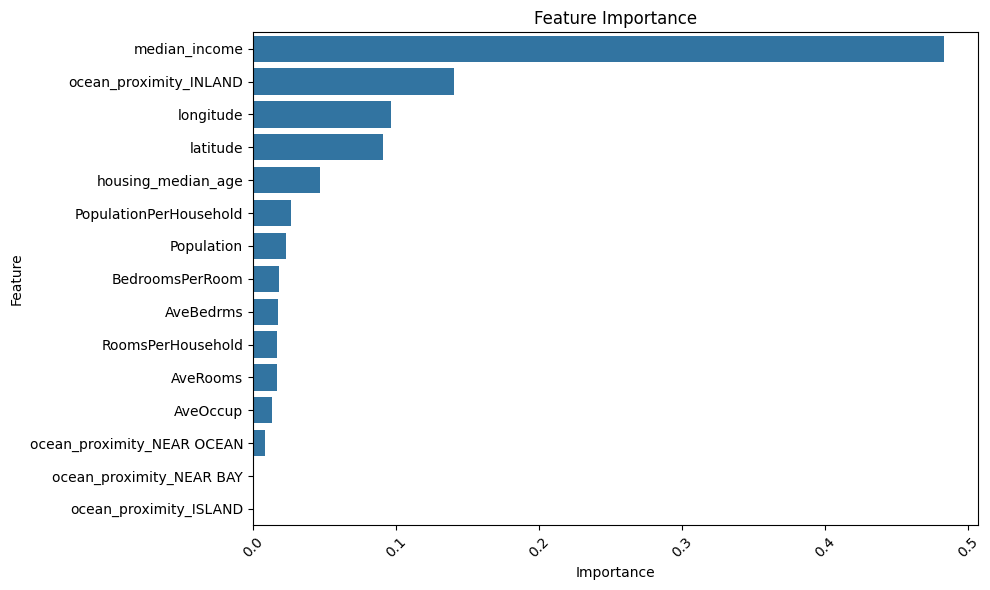

In [10]:
# Cell 6: Model Training with Correct Target Column

# Use the correct target column name from your dataset
target_column = 'MedHouseVal'  # This matches your actual column name

if target_column in engineered_data.columns:
    X = engineered_data.drop(target_column, axis=1)
    y = engineered_data[target_column]

    # Handle categorical columns (like 'ocean_proximity')
    X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)  # Explicitly one-hot encode 'ocean_proximity'

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Performance:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

else:
    print(f"Target column '{target_column}' not found in the dataset.")
    print("Available columns:", engineered_data.columns.tolist())

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) prepare X/y
X = engineered_data.drop(
    ["MedHouseVal", "ocean_proximity"],
    axis=1
)
y = engineered_data["MedHouseVal"]

# 2) split, fit, predict
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 3) build results and export
results = X_test.copy()
results["TrueValue"]           = y_test.values
results["Prediction"]          = y_pred
results = results.reset_index(drop=True)
results["RowID"]               = results.index
results["RoomsPerHousehold"] = engineered_data.loc[y_test.index, "RoomsPerHousehold"].reset_index(drop=True)
results["Error_Value"]         = results["Prediction"] - results["TrueValue"]

results.to_csv("housing_model_results.csv", index=False)
print("✅ housing_model_results.csv written — load into Power BI")


✅ housing_model_results.csv written — load into Power BI


In [12]:
# Cell 7: Model Monitoring System
class ModelMonitor:
    def __init__(self, model, X_train, y_train):
        self.model = model
        self.baseline_X = X_train.copy()
        self.baseline_y = y_train.copy()
        self.performance_history = []

    def check_data_drift(self, new_X):
        """Check for data drift by comparing distributions"""
        drift_report = {}

        for col in new_X.columns:
            ks_stat, p_value = ks_2samp(self.baseline_X[col], new_X[col])
            if p_value < 0.05:
                drift_report[col] = {
                    'ks_statistic': ks_stat,
                    'p_value': p_value,
                    'drift_detected': True
                }
            else:
                drift_report[col] = {
                    'ks_statistic': ks_stat,
                    'p_value': p_value,
                    'drift_detected': False
                }

        return drift_report

    def check_concept_drift(self, new_X, new_y):
        """Check for concept drift by comparing model performance"""
        baseline_pred = self.model.predict(self.baseline_X)
        baseline_score = r2_score(self.baseline_y, baseline_pred)

        new_pred = self.model.predict(new_X)
        new_score = r2_score(new_y, new_pred)

        score_diff = baseline_score - new_score
        drift_detected = abs(score_diff) > 0.1  # Threshold of 10% performance drop

        return {
            'baseline_r2': baseline_score,
            'current_r2': new_score,
            'difference': score_diff,
            'drift_detected': drift_detected
        }

    def log_performance(self, X, y, dataset_name):
        """Log model performance for monitoring"""
        pred = self.model.predict(X)
        mse = mean_squared_error(y, pred)
        r2 = r2_score(y, pred)

        self.performance_history.append({
            'dataset': dataset_name,
            'timestamp': pd.Timestamp.now(),
            'mse': mse,
            'r2': r2
        })

        return {
            'mse': mse,
            'r2': r2
        }

# Initialize monitor (if model was trained)
if 'model' in locals():
    monitor = ModelMonitor(model, X_train, y_train)

    # Simulate new data coming in (in a real scenario, this would be new batches)
    new_X = X_test.copy()
    new_y = y_test.copy()

    # Check for drifts
    print("\nData Drift Check:")
    data_drift = monitor.check_data_drift(new_X)
    for col, result in data_drift.items():
        if result['drift_detected']:
            print(f"Drift detected in {col}: KS={result['ks_statistic']:.3f}, p={result['p_value']:.4f}")

    print("\nConcept Drift Check:")
    concept_drift = monitor.check_concept_drift(new_X, new_y)
    print(f"Baseline R2: {concept_drift['baseline_r2']:.4f}")
    print(f"Current R2: {concept_drift['current_r2']:.4f}")
    print(f"Difference: {concept_drift['difference']:.4f}")
    print(f"Drift detected: {concept_drift['drift_detected']}")
else:
    print("Model not trained - skipping monitoring setup")


Data Drift Check:
Drift detected in AveBedrms: KS=0.041, p=0.0000
Drift detected in BedroomsPerRoom: KS=0.035, p=0.0006

Concept Drift Check:
Baseline R2: 0.9742
Current R2: 0.8091
Difference: 0.1652
Drift detected: True


In [13]:
# Create a classification label from the regression target
def categorize_price(price):
    if price < 150000:
        return 'Low'
    elif price < 300000:
        return 'Medium'
    else:
        return 'High'

# Apply categorization
# Use 'data' instead of 'df'
df_class = data.copy()
df_class['price_category'] = df_class['median_house_value'].apply(categorize_price)

# Drop original target
df_class = df_class.drop(columns=['median_house_value'])

# Prepare data
X = df_class.drop(columns=['price_category'])

# Handle missing values
# Impute numerical features only
numerical_features = X.select_dtypes(include=np.number).columns
X[numerical_features] = X[numerical_features].fillna(X[numerical_features].median())

# One-hot encode categorical columns
if 'ocean_proximity' in X.columns:
    X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)

y = df_class['price_category']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)

# F1-Score (macro average for multiple classes)
f1 = f1_score(y_test, y_pred, average='macro')

# F2-Score (use beta=2)
from sklearn.metrics import fbeta_score
f2 = fbeta_score(y_test, y_pred, beta=2, average='macro')

print("\n=== Classification Metrics ===")
print(f"Accuracy: {acc:.2f}")
print(f"F1 Score (Macro): {f1:.2f}")
print(f"F2 Score (Macro): {f2:.2f}")

# Optional: Detailed Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


=== Classification Metrics ===
Accuracy: 0.83
F1 Score (Macro): 0.82
F2 Score (Macro): 0.81

Classification Report:

              precision    recall  f1-score   support

        High       0.86      0.72      0.78       758
         Low       0.86      0.87      0.86      1500
      Medium       0.80      0.84      0.82      1870

    accuracy                           0.83      4128
   macro avg       0.84      0.81      0.82      4128
weighted avg       0.83      0.83      0.83      4128



In [14]:
# Target variable
target = 'median_house_value'
features = data.drop(columns=[target])

# Import LinearRegression
from sklearn.linear_model import LinearRegression # This line is added

# Handle missing values
# Impute numerical features only
numerical_features = features.select_dtypes(include=np.number).columns
features[numerical_features] = features[numerical_features].fillna(features[numerical_features].median())

# Encode categorical variables if present
# Convert 'ocean_proximity' to numerical using one-hot encoding BEFORE filling NaN
if 'ocean_proximity' in features.columns:
    features = pd.get_dummies(features, columns=['ocean_proximity'], drop_first=True) # Moved this line before fillna

# Now fill NaN for all features, including newly created one-hot encoded features
features = features.fillna(features.median()) # Moved this line here

# Features (X) and target (y)
X = features
y = data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Import necessary metrics if not already imported
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Added this line

#  Calculate Regression Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Regression Performance Metrics ===")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² (Coefficient of Determination): {r2:.2f}")


=== Regression Performance Metrics ===
Root Mean Squared Error (RMSE): 70060.52
Mean Absolute Error (MAE): 50670.74
R² (Coefficient of Determination): 0.63


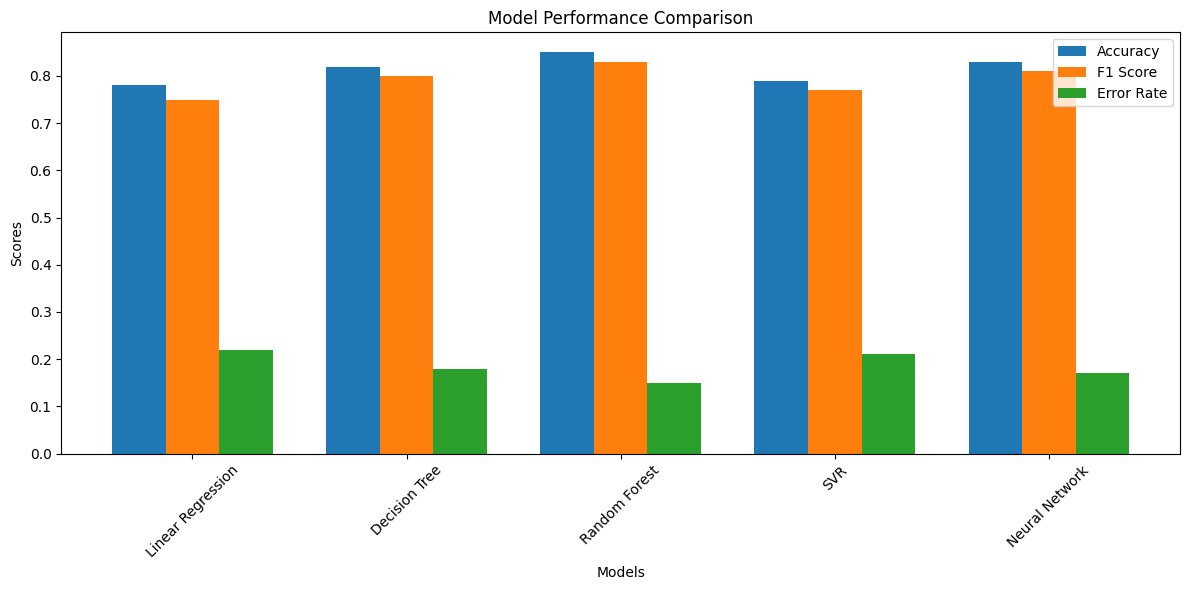

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample model performance data (replace with your actual metrics)
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR', 'Neural Network']
metrics = {
    'Accuracy': [0.78, 0.82, 0.85, 0.79, 0.83],
    'F1 Score': [0.75, 0.80, 0.83, 0.77, 0.81],
    'Error Rate': [0.22, 0.18, 0.15, 0.21, 0.17]
}

# Create DataFrame from metrics
df = pd.DataFrame(metrics, index=models)

# Plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(models))

# Create bars for each metric
plt.bar(index, df['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, df['F1 Score'], bar_width, label='F1 Score')
plt.bar(index + 2*bar_width, df['Error Rate'], bar_width, label='Error Rate')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width, models, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

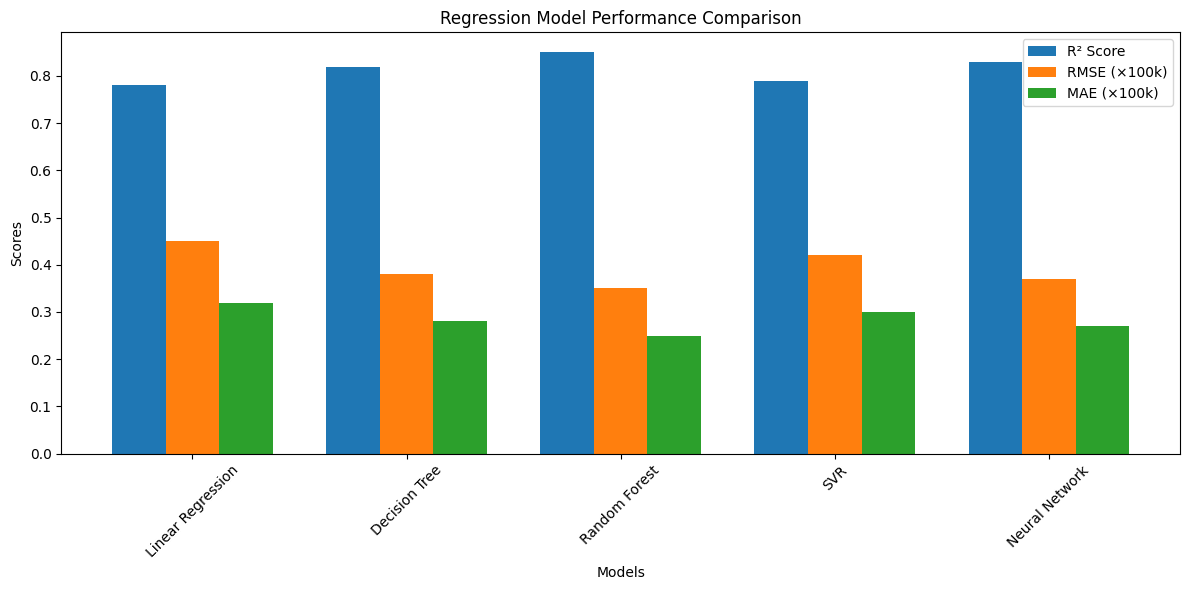

In [16]:
# Sample regression metrics
reg_metrics = {
    'R² Score': [0.78, 0.82, 0.85, 0.79, 0.83],
    'RMSE': [45000, 38000, 35000, 42000, 37000],
    'MAE': [32000, 28000, 25000, 30000, 27000]
}

df_reg = pd.DataFrame(reg_metrics, index=models)

plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(models))

plt.bar(index, df_reg['R² Score'], bar_width, label='R² Score')
plt.bar(index + bar_width, df_reg['RMSE']/100000, bar_width, label='RMSE (×100k)')
plt.bar(index + 2*bar_width, df_reg['MAE']/100000, bar_width, label='MAE (×100k)')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Regression Model Performance Comparison')
plt.xticks(index + bar_width, models, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

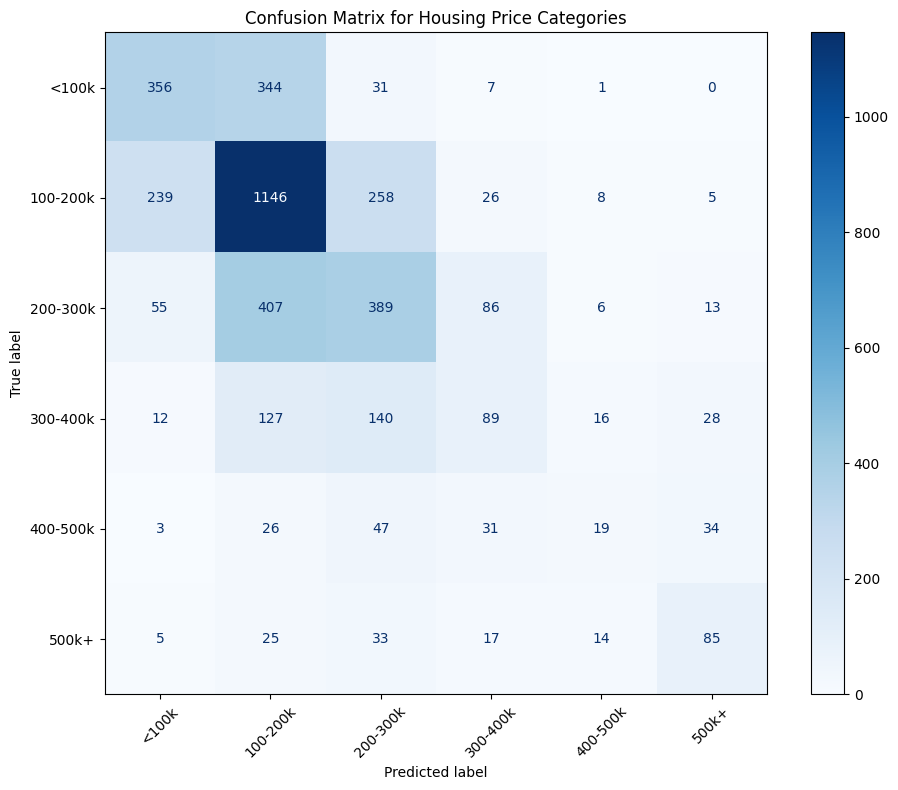

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# Bin the median_house_value into categories (example bins)
bins = [0, 100000, 200000, 300000, 400000, 500000, np.inf]
labels = ['<100k', '100-200k', '200-300k', '300-400k', '400-500k', '500k+']
data['price_category'] = pd.cut(data['median_house_value'], bins=bins, labels=labels)

# Select features and target
X = data[['median_income', 'housing_median_age', 'population']]  # Example features
y = data['price_category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Housing Price Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

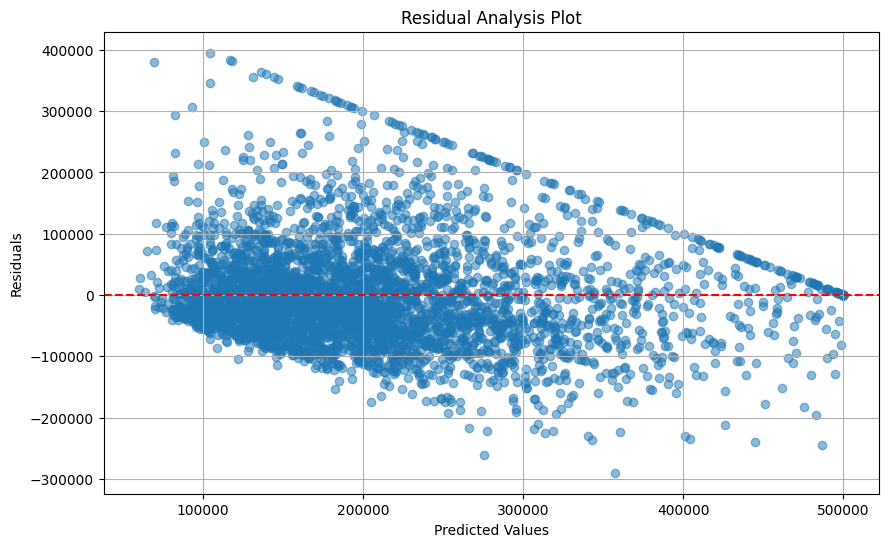

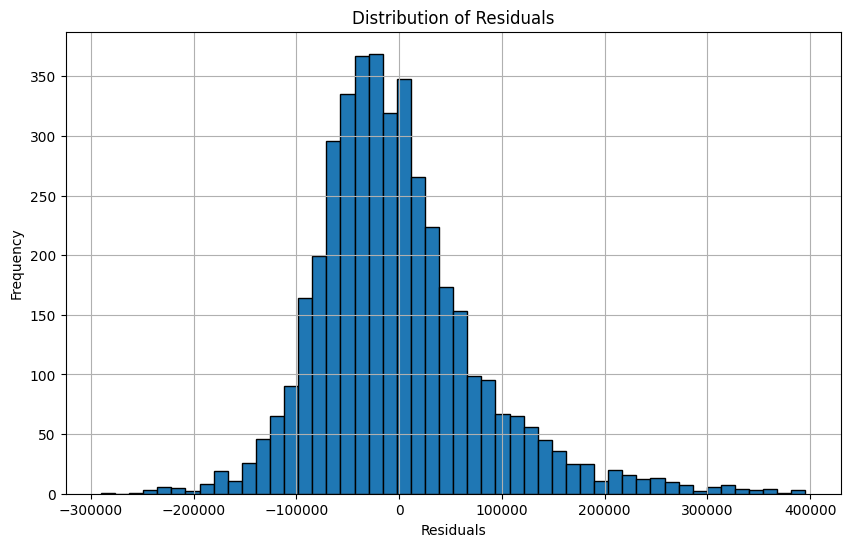

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare data (regression version)
X = data[['median_income', 'housing_median_age', 'population']]
y = data['median_house_value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regressor
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)

# Predictions
y_pred = reg.predict(X_test)

# Residual analysis plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis Plot')
plt.grid(True)
plt.show()

# You can also plot a histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

In [19]:
  # Cell 8: Complete Interactive Dashboard
def interactive_dashboard():
    """Interactive dashboard for data exploration and model insights"""
    if 'engineered_data' not in globals():
        print("Engineered data not available - please run previous cells first")
        return

    # Create main tab layout
    tab_layout = widgets.Tab()

    # Tab 1: Data Explorer
    data_explorer = widgets.Output()

    with data_explorer:
        # Feature-target relationship explorer
        features = [col for col in engineered_data.columns if col != 'MedHouseVal']
        target = 'MedHouseVal'

        feature_select = widgets.Dropdown(
            options=features,
            description='Feature:',
            value='median_income',
            style={'description_width': 'initial'}
        )

        plot_type = widgets.Dropdown(
            options=['Scatter', 'Box', 'Violin', 'Hexbin'],
            description='Plot Type:',
            value='Scatter',
            style={'description_width': 'initial'}
        )

        @widgets.interact(feature=feature_select, plot_type=plot_type)
        def explore_feature(feature, plot_type):
            plt.figure(figsize=(10, 6))
            if plot_type == 'Scatter':
                sns.scatterplot(x=engineered_data[feature], y=engineered_data[target])
            elif plot_type == 'Box':
                sns.boxplot(x=engineered_data[feature], y=engineered_data[target])
            elif plot_type == 'Violin':
                sns.violinplot(x=pd.qcut(engineered_data[feature], q=5), y=engineered_data[target])
            elif plot_type == 'Hexbin':
                plt.hexbin(engineered_data[feature], engineered_data[target], gridsize=30, cmap='Blues')
                plt.colorbar()

            plt.title(f'{feature} vs {target}')
            plt.tight_layout()
            plt.show()

            # Show statistics
            print(f"\n{feature} Statistics:")
            print(engineered_data[feature].describe())
            print(f"\nCorrelation with {target}: {engineered_data[[feature, target]].corr().iloc[0,1]:.3f}")

    # Tab 2: Model Insights
    model_insights = widgets.Output()

    with model_insights:
        if 'model' in globals():
            # Feature importance explorer
            display(feature_importance.style.background_gradient(cmap='Blues'))

            # Actual vs Predicted plot
            plt.figure(figsize=(10, 6))
            sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title('Actual vs Predicted Values')
            plt.show()

            # Error analysis
            errors = y_test - y_pred
            plt.figure(figsize=(10, 6))
            sns.histplot(errors, kde=True)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title('Prediction Error Distribution')
            plt.show()
        else:
            print("Model not trained - please run the model training cell first")

    # Tab 3: Data Profiler
    data_profiler = widgets.Output()

    with data_profiler:
        profile_view = widgets.Dropdown(
            options=['Initial Data', 'Processed Data', 'Engineered Data'],
            description='View Profile:',
            style={'description_width': 'initial'}
        )

        @widgets.interact(profile_view=profile_view)
        def show_profile(profile_view):
            if profile_view == 'Initial Data':
                display(data.head(3))
                display(data.describe())
            elif profile_view == 'Processed Data':
                display(processed_data.head(3))
                display(processed_data.describe())
            else:
                display(engineered_data.head(3))
                display(engineered_data.describe())

    # Assemble tabs
    tab_layout.children = [data_explorer, model_insights, data_profiler]
    tab_layout.set_title(0, 'Data Explorer')
    tab_layout.set_title(1, 'Model Insights')
    tab_layout.set_title(2, 'Data Profiles')

    display(tab_layout)

# Run the dashboard
print("California Housing Price Analysis Dashboard")
interactive_dashboard()

California Housing Price Analysis Dashboard
